In [3]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
import itertools
import time
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import cross_val_score
from tabulate import tabulate
import optuna
from joblib import dump
from joblib import load



#### Data Loading and Initial Exploration


In [4]:
# load Train data
train_data = pd.read_csv('/Users/maryam/ML-IDS/Dataset/Train_data.csv')
# load Test data
test_data = pd.read_csv('/Users/maryam/ML-IDS/Dataset/Test_data.csv')


In [5]:
# we will use the following features to train our model
train_data.head()

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   
3                    1.00                    0.00   
4                    1.00                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                         0.88                         0.00   
2                         0.00                         0.00   
3                         0.03                         0.04   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                  0.05   
1                  0.00                      0.00                  0.00   
2                  1.00                      1.00                  0.00   
3                  0.03                      0.01                  0.00   
4                  0.00                      0.00                  0.00   

   dst_host_srv_rerror_rate    class  
0                      0.00   normal  
1                      0.00   normal  
2                      0.00  anomaly  
3                      0.01   normal  
4                      0.00   normal  

[5 rows x 42 columns]

In [6]:
# we will use the following features to test our model
test_data.head()

duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         0           tcp   private   REJ          0          0     0   
1         0           tcp   private   REJ          0          0     0   
2         2           tcp  ftp_data    SF      12983          0     0   
3         0          icmp     eco_i    SF         20          0     0   
4         1           tcp    telnet  RSTO          0         15     0   

   wrong_fragment  urgent  hot  ...  dst_host_count  dst_host_srv_count  \
0               0       0    0  ...             255                  10   
1               0       0    0  ...             255                   1   
2               0       0    0  ...             134                  86   
3               0       0    0  ...               3                  57   
4               0       0    0  ...              29                  86   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.04                    0.06   
1                    0.00                    0.06   
2                    0.61                    0.04   
3                    1.00                    0.00   
4                    0.31                    0.17   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.00                         0.00   
1                         0.00                         0.00   
2                         0.61                         0.02   
3                         1.00                         0.28   
4                         0.03                         0.02   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                  1.00   
1                   0.0                       0.0                  1.00   
2                   0.0                       0.0                  0.00   
3                   0.0                       0.0                  0.00   
4                   0.0                       0.0                  0.83   

   dst_host_srv_rerror_rate  
0                      1.00  
1                      1.00  
2                      0.00  
3                      0.00  
4                      0.71  

[5 rows x 41 columns]

In [7]:
# General information and statistics about the train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [8]:
# describe the train data
train_data.describe(include='object')

protocol_type service   flag   class
count          25192   25192  25192   25192
unique             3      66     11       2
top              tcp    http     SF  normal
freq           20526    8003  14973   13449

In [9]:
train_data.shape

(25192, 42)

#### Data Cleaning and Preprocessing

In [10]:
# Checking for missing values and duplicates
missing_values = train_data.isnull().sum()
total = train_data.shape[0]
missing_columns = [col for col in train_data.columns if train_data[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train_data[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

In [11]:
# Checking for duplicate rows
print(f"Number of duplicate rows: {train_data.duplicated().sum()}")

Number of duplicate rows: 0


<AxesSubplot:xlabel='class', ylabel='count'>

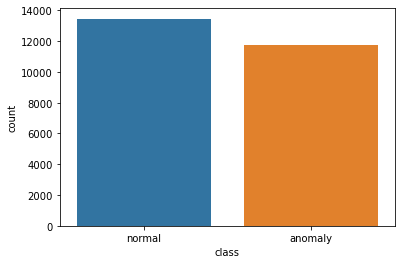

In [12]:
# Class distribution in Training set

sns.countplot(x=train_data['class'])

In [13]:
print('Class distribution Training set:')
print(train_data['class'].value_counts())

Class distribution Training set:
normal     13449
anomaly    11743
Name: class, dtype: int64


In [14]:

# Encoding categorical features
def label_encode(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            label_encoder = LabelEncoder()
            df[col] = label_encoder.fit_transform(df[col])

label_encode(train_data)
label_encode(test_data)


In [15]:
# why drop this column?
# The column num_outbound_cmds has only one unique value, so it is not useful for our model
train_data.drop(['num_outbound_cmds'], axis=1, inplace=True)
test_data.drop(['num_outbound_cmds'], axis=1, inplace=True)

#### Feature Selection and Normalization

In [16]:
# Splitting data into features and target
X_train = train_data.drop(['class'], axis=1)
Y_train = train_data['class']

In [17]:
# What is happening in this code
# Random Forest Classifier is used to rank the importance of features
# RFE is used to select the most important features
# we will use 5 features in our model
# we will use the selected features to train our model
# we will use the selected features to test our model

# Feature selection using Random Forest Classifier
rfc = DecisionTreeClassifier()  # Using Decision Tree for feature selection
rfe = RFE(rfc, n_features_to_select=5)
rfe = rfe.fit(X_train, Y_train)

# Selecting important features
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]
selected_features

['protocol_type',
 'src_bytes',
 'dst_bytes',
 'dst_host_srv_count',
 'dst_host_same_srv_rate']

In [18]:
# Train data with selected features
X_train = X_train[selected_features]

In [19]:
# Scaling features why? and what is the purpose of scaling?
# Scaling is used to standardize the range of independent variables or features of the data
# StandardScaler is used to scale the features
# we will use the scaled features to train our model

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test_data)


In [20]:

# Splitting the dataset for training and testing
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=42)

#### Decision Tree Model Training and Tuning

In [21]:

# Training a basic Decision Tree Classifier
# Time to train the model
clfd = DecisionTreeClassifier(criterion ="entropy", max_depth = 4)
start_time = time.time()
clfd.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)

Training time:  0.014342784881591797


In [22]:
# Time taken to test the model
start_time = time.time()
y_test_pred = clfd.predict(x_train)
end_time = time.time()
print("Testing time: ", end_time-start_time)

Testing time:  0.0019221305847167969


In [23]:

# Hyperparameter Tuning for Decision Tree using Optuna
def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 5, log=False)
    classifier_obj = DecisionTreeClassifier(max_features=dt_max_features, max_depth=dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy


In [24]:
# start the optimization process
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

[I 2024-02-03 14:15:58,823] A new study created in memory with name: no-name-e1af01c2-22ce-474b-9d22-41d3f22a2c76
[I 2024-02-03 14:15:58,849] Trial 0 finished with value: 0.9944429743318338 and parameters: {'dt_max_depth': 30, 'dt_max_features': 4}. Best is trial 0 with value: 0.9944429743318338.
[I 2024-02-03 14:15:58,863] Trial 1 finished with value: 0.9718179412543001 and parameters: {'dt_max_depth': 3, 'dt_max_features': 5}. Best is trial 0 with value: 0.9944429743318338.
[I 2024-02-03 14:15:58,880] Trial 2 finished with value: 0.990209050013231 and parameters: {'dt_max_depth': 16, 'dt_max_features': 2}. Best is trial 0 with value: 0.9944429743318338.
[I 2024-02-03 14:15:58,909] Trial 3 finished with value: 0.9945752844667901 and parameters: {'dt_max_depth': 14, 'dt_max_features': 5}. Best is trial 3 with value: 0.9945752844667901.
[I 2024-02-03 14:15:58,938] Trial 4 finished with value: 0.9944429743318338 and parameters: {'dt_max_depth': 27, 'dt_max_features': 5}. Best is trial 3 

FrozenTrial(number=12, state=TrialState.COMPLETE, values=[0.9949722148716592], datetime_start=datetime.datetime(2024, 2, 3, 14, 15, 59, 190731), datetime_complete=datetime.datetime(2024, 2, 3, 14, 15, 59, 230928), params={'dt_max_depth': 20, 'dt_max_features': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=5, log=False, low=2, step=1)}, trial_id=12, value=None)


In [25]:

# Training the Decision Tree model with the best parameters
dt = DecisionTreeClassifier(max_features=study_dt.best_trial.params['dt_max_features'], max_depth=study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=20, max_features=5)

#### Model Evaluation

In [26]:
# Model Performance Metrics
dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)
print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")


Train Score: 0.9985822842236588
Test Score: 0.9949722148716592


In [27]:

# Cross-Validation
scores = cross_val_score(dt, x_train, y_train, cv=10, scoring='accuracy')
print(f"Cross-Validation Accuracy: {np.mean(scores)}")

Cross-Validation Accuracy: 0.9921175446922955


In [28]:
# Confusion Matrix and Classification Report
y_pred = dt.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

[[3502   14]
 [  24 4018]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3516
           1       1.00      0.99      1.00      4042

    accuracy                           0.99      7558
   macro avg       0.99      1.00      0.99      7558
weighted avg       0.99      0.99      0.99      7558

F1 Score: 0.9952935348030715


#### Summary Table

In [29]:

# Creating a summary table of model performance
data = [["Decision Tree", dt_train, dt_test, np.mean(scores), f1]]
col_names = ["Model", "Train Score", "Test Score", "CV Accuracy", "F1 Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════════╤═══════════════╤══════════════╤═══════════════╤════════════╕
│ Model         │   Train Score │   Test Score │   CV Accuracy │   F1 Score │
╞═══════════════╪═══════════════╪══════════════╪═══════════════╪════════════╡
│ Decision Tree │      0.998582 │     0.994972 │      0.992118 │   0.995294 │
╘═══════════════╧═══════════════╧══════════════╧═══════════════╧════════════╛


#### Saving the model

In [30]:
# Save the model to a file
model_filename = 'decision_tree_model.joblib'
dump(dt, model_filename)
print(f"Model saved to {model_filename}")

Model saved to decision_tree_model.joblib


#### Load the model

In [31]:
# Load the model from the file
loaded_model = load(model_filename)
print("Model loaded successfully")

Model loaded successfully


In [33]:
from scapy.all import sniff, IP, TCP, UDP
from collections import defaultdict
import re

# Network traffic analysis class
class NetworkTrafficAnalysis:
    def __init__(self):
        # Stores the number of connections to the same destination service
        self.dst_host_srv_count = defaultdict(int)
        # Tracks src_bytes per connection
        self.src_bytes = defaultdict(int)
        # Tracks dst_bytes per connection (responses)
        self.dst_bytes = defaultdict(int)
        # Tracks 'hot' indicators
        self.hot = defaultdict(int)
        # Regex pattern to detect 'hot' activities (example: password in payload)
        self.hot_pattern = re.compile(br'(login|password|<suspicious_pattern>)', re.IGNORECASE)

    def process_packet(self, packet):
            # Initialize default values
        protocol_type = None
        src_bytes = 0
        dst_bytes = 0
        service = None
        
        # Extract protocol type
        protocol_type = None
        if IP in packet:
            protocol_type = packet[IP].proto
        
        # Initial src_bytes and dst_bytes are zero
        src_bytes = 0
        dst_bytes = 0

        # Check if it's a TCP/UDP packet and calculate src_bytes
        if TCP in packet and packet[TCP].payload:
            payload = packet[TCP].load if packet[TCP].payload else b""
            # Ensure the payload is bytes and not a string
            if isinstance(payload, str):
                payload = payload.encode()  # Convert to bytes if necessary
            if self.hot_pattern.search(payload):
                self.hot[service] += 1  # Increment hot counter for the service

        # Placeholder for real response packet handling logic for dst_bytes
        # In a real scenario, you would match this packet to its response based on some criteria
        # such as IP pairs and ports (a 4-tuple), and calculate dst_bytes from that

        # Check for 'hot' activities in payload
        if TCP in packet and packet[TCP].payload:
            payload = packet[TCP].load if packet[TCP].payload else ""
            if self.hot_pattern.search(payload):
                self.hot[service] += 1  # Increment hot counter for the service

        # Print out the packet information
        print(f"Protocol Type: {protocol_type}, Source Bytes: {src_bytes}, Destination Bytes: {dst_bytes}")
        print(f"Destination Host Service Count: {self.dst_host_srv_count[service]}, Hot Count: {self.hot[service]}")

    def start_capture(self):
        # Start live packet capture
        sniff(prn=self.process_packet, store=0)

# Create an instance of the traffic analysis system
analysis_system = NetworkTrafficAnalysis()

# Start the live capture and analysis
analysis_system.start_capture()


Protocol Type: 17, Source Bytes: 0, Destination Bytes: 0
Destination Host Service Count: 0, Hot Count: 0
Protocol Type: 17, Source Bytes: 0, Destination Bytes: 0
Destination Host Service Count: 0, Hot Count: 0
Protocol Type: 17, Source Bytes: 0, Destination Bytes: 0
Destination Host Service Count: 0, Hot Count: 0
Protocol Type: 17, Source Bytes: 0, Destination Bytes: 0
Destination Host Service Count: 0, Hot Count: 0
Protocol Type: 17, Source Bytes: 0, Destination Bytes: 0
Destination Host Service Count: 0, Hot Count: 0
Protocol Type: 17, Source Bytes: 0, Destination Bytes: 0
Destination Host Service Count: 0, Hot Count: 0
Protocol Type: 17, Source Bytes: 0, Destination Bytes: 0
Destination Host Service Count: 0, Hot Count: 0
Protocol Type: 17, Source Bytes: 0, Destination Bytes: 0
Destination Host Service Count: 0, Hot Count: 0
Protocol Type: 17, Source Bytes: 0, Destination Bytes: 0
Destination Host Service Count: 0, Hot Count: 0
Protocol Type: 17, Source Bytes: 0, Destination Bytes: 

In [39]:
# Save the captured data to a CSV file
def save_to_csv(self, filename):
    # Convert the data to a DataFrame
    data = {
        "dst_host_srv_count": list(self.dst_host_srv_count.values()),
        "src_bytes": list(self.src_bytes.values()),
        "dst_bytes": list(self.dst_bytes.values()),
        "hot": list(self.hot.values())
    }
    df = pd.DataFrame(data)
    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)



In [ ]:
from scapy.all import sniff, IP, TCP
import pandas as pd

# Network traffic analysis class
class NetworkTrafficAnalysis:
    def __init__(self):
        # Initialize lists to store captured data
        self.captured_data = []

    def process_packet(self, packet):
        # Extract the information you need from the packet
        protocol_type = None
        src_bytes = 0
        dst_bytes = 0

        if IP in packet:
            protocol_type = packet[IP].proto

        if TCP in packet:
            src_bytes = len(packet[TCP].payload)
            dst_bytes = len(packet) - len(packet[TCP].payload)

        # Create a dictionary to store packet information
        packet_info = {
            "Protocol Type": protocol_type,
            "Source Bytes": src_bytes,
            "Destination Bytes": dst_bytes
        }

        # Append the packet information to the captured data list
        self.captured_data.append(packet_info)

    def save_to_csv(self, filename):
        # Convert the captured data list to a DataFrame
        df = pd.DataFrame(self.captured_data)

        # Save the DataFrame to a CSV file
        df.to_csv(filename, index=False)
        print(f"Captured data saved to {filename}")

    def start_capture(self):
        # Start live packet capture
        sniff(prn=self.process_packet, store=0)

# Create an instance of the traffic analysis system
analysis_system = NetworkTrafficAnalysis()

# Start the live capture and analysis
analysis_system.start_capture()

# Allow some time for capturing data (you can stop it manually when ready)

# Save the captured data to a CSV file
analysis_system.save_to_csv("captured_traffic.csv")
